# Notebook: *k*-means and GMM for clustering

In this notebook, we present the *k*-**means** and **Gaussian Mixture Models** algorithms. In this notebook, we will cover a basic understanding of the **Expectation Maximization (EM)** algorithm which, not only forms the basis of several machine learning algorithms, including *k*-means, and Gaussian Mixture Models, but also has lots of applications. We will also cover the *k*-means algorithm which is a form of EM, and its weaknesses. Finally we will discuss how Gaussian Mixture Models improve on several of *k*-means weaknesses.

## Contents
The structure of the notebook is as follows:
* Introducing *k*-means
* *k*-means Algorithm: Expectation–Maximization
* Clustering on real data: SNPs Database
* Weaknesses of *k*-means
* Generalizing E–M: Gaussian Mixture Models


## Sources
<!--BOOK_INFORMATION-->
*This notebook has been modified by Aythami Morales from:

i) [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas.

ii) [Intro to Expectation-Maximization, K-Means, Gaussian Mixture Models with Python, Sklearn](http://www.blackarbs.com/blog/intro-to-expectation-maximization-k-means-gaussian-mixture-models-with-python-sklearn/3/20/2017)

iii) [GMM covariances](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py) by Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>




## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
# sklearn includes kmeans algorithm
from sklearn.cluster import KMeans

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

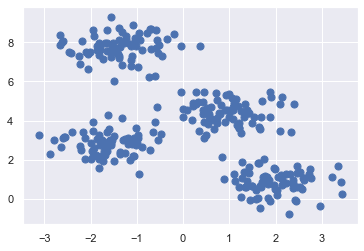

In [2]:
# male_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
# two of the most important paremeters of k-means are the number of clusters and the initialization
# here we will use four clusters and random initialization
kmeans = KMeans(n_clusters=4)

# estimate model parameters with the EM algorithm
kmeans.fit(X)

# predict the closest cluster each sample in X belongs to
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

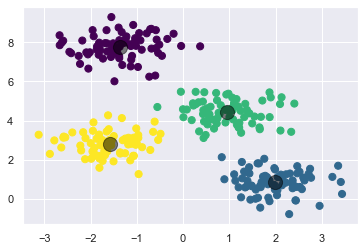

In [4]:
# plot the original data and the predicted clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-means algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:
Guess some cluster centers
Repeat until converged
E-Step: assign points to the nearest cluster center
M-Step: set the cluster centers to the mean 
Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.
The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

The *k*-means algorithm is simple enough that we can write it in a few lines of code. See ./my_modules/my_module.py for a complete implementation of the algorithm

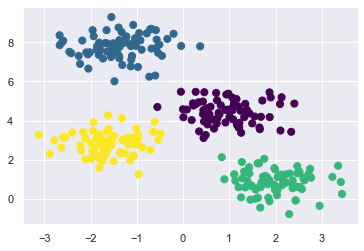

In [5]:
# add your modules to the path
import sys
sys.path.append('./my_modules')

# my_module is an example of python module created to include your functions
import my_module

# in the function my_module.find_cluster you have a simple implementation of the k-means algortihm
# the output of the function are the centers of the clusters and the labels asigned to each data sample
centers, labels = my_module.find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Let's see how it works step by step

In [6]:
%matplotlib inline
# we can modify the number of clusters and see step by step the results of the EM algorithm.
my_module.plot_kmeans_interactive();

interactive(children=(Dropdown(description='frame', options=(0, 50), value=0), Dropdown(description='n_cluster…

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

## Clustering on real data: SNPs Database

To start, let's take a look at applying *k*-means on the same data used for the previous notebook (notebook 2 PCA). Here we will attempt to use *k*-means to try to identify similar SNPs clusters; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information. 

First, we will repeat the PCA analysis done in previous notebook without the population and superpopulation data.

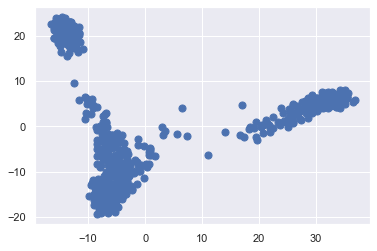

In [7]:
from sklearn.decomposition import PCA
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# read the SNP table
df_snp = pd.read_csv('./data/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()

# convert the dato to type float
df_snp = df_snp.astype(np.float)

# standardize the data before performing PCA
# we use .drop to remove the gender, pop and super_pop columns to avoid errors.
df_snp_std = sklearn.preprocessing.StandardScaler().fit_transform(
                            df_snp)

# define the number of components of the PCA domain
n_components=50
snp_pca = PCA(n_components=n_components) # Actua sobre 50 caracteristicas y plotea solo 2. Por eso veras que un cluster esta en medio de otro 

# project the data into this new PCA space
snp_pca.fit(df_snp_std)
df_snp_pca = snp_pca.transform(df_snp_std)

# convert dataframe to array
X=np.array(df_snp_pca)

# plot first two PC without labels
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');

Secondly, we will show the projected data without labels (prior information).

As we can see, some clusters can be easily identified. The goal now is to use *k*-means to automatically locate such clusters. In the ideal case, the clusters will be similar to superpopulation labels available in the training data.

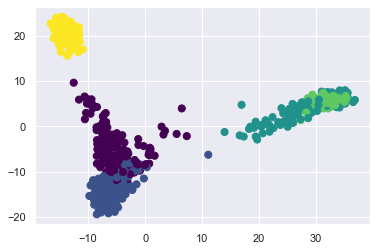

In [8]:
# perform k-means clustering
centers, labels = my_module.find_clusters(X, 5)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Now we plot the original labels to compare with our clustering prediction.

Remember that real labels were available from the information provided with the database: 
![alt text](./data/PCA_results.png)


The results show how *k*-means has correctly grouped SNPs data from all superpopulations except for the African subjects (grouped into two clusters). Note that information about the population or superpopulation was not used during PCA training and *k*-means clustering.

## Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved:
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

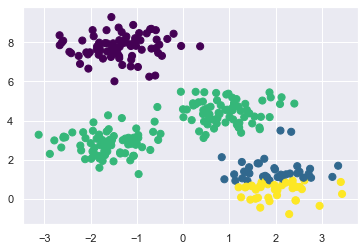

In [9]:
# male_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# we will modify the seed of the random initialization of the centroids
centers, labels = my_module.find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: **it cannot learn the number of clusters from the data.**
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:



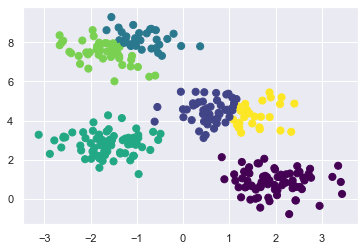

In [10]:
# we repeat the kmeans with 6 clusters
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, **with a radius defined by the most distant point in the cluster.**
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


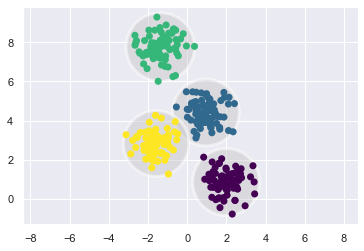

In [11]:
# once again, we execute kmeans with four clusters
kmeans = KMeans(n_clusters=4, random_state=0)
print(kmeans)

#let's plot the clustering as a sphere
my_module.plot_kmeans(kmeans, X)

**An important observation for *k*-means is that these cluster models *must be circular**: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

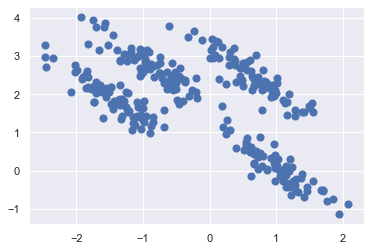

In [12]:
# we read a new synthetic data with an elliptical shape
X_stretched = np.load("./data/data_stretched.npy")
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], s=50);

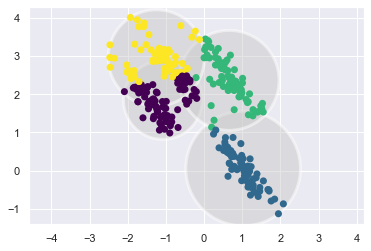

In [13]:
# repeat the k-means algorithm with four clusters for this new dataset
kmeans = KMeans(n_clusters=4, random_state=0)
my_module.plot_kmeans(kmeans, X_stretched)


The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

**In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.**
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

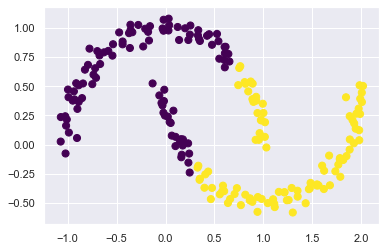

In [14]:
# make_moons allows to generate synthetic data to test algorithms
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

# run the k-means algorithm  with two clusters
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation **by preprocessing the data with PCA (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), but in practice there is no guarantee that such a global operation will circularize the individual data.**

**These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.**

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

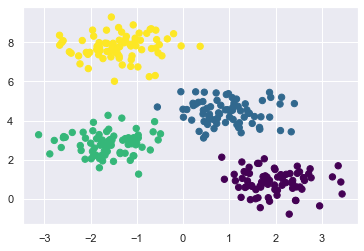

In [15]:
# import the Gaussian Mixture Model algorithm from sklearn
from sklearn.mixture import GaussianMixture as GMM

# make_blobs is a function used to create synthetic data that can be used to test algorithms
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# estimate model parameters with the EM algorithm, we will use four gaussian functions
gmm = GMM(n_components=4).fit(X)

# predict the labels for the data samples in X using trained model
labels = gmm.predict(X) # te dice a que cluster ha asignado cada dato
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [16]:
# predict posterior probability of each component given the data
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.972 0.026 0.002 0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.999 0.001 0.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

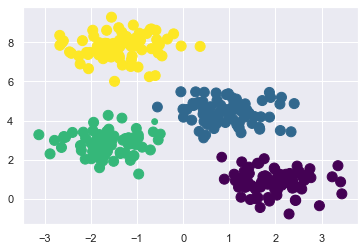

In [17]:
# square emphasizes differences
size = 100 * probs.max(1) ** 2 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
**Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.**

We can take a look at what the four-component GMM gives us for our initial data:

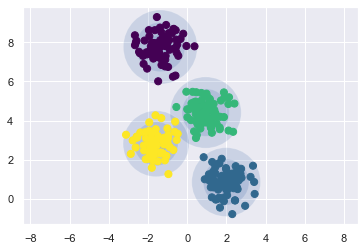

In [18]:
# estimate model parameters with the EM algorithm using four gaussians, initialization seed and spherical covariance 
gmm = GMM(n_components=4, random_state=42, covariance_type='spherical')
my_module.plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

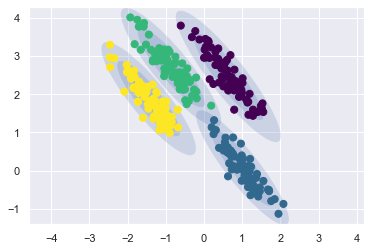

In [19]:
# we read a new synthetic daya with an elliptical shape
X_stretched = np.load("./data/data_stretched.npy")

# estimate model parameters with the EM algorithm using four gaussians, random initialization and full covariance 
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
my_module.plot_gmm(gmm, X_stretched)

**This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.**

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function.

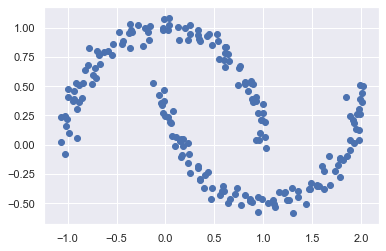

In [20]:
# make_moons allows to generate synthetic data to test algorithms
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

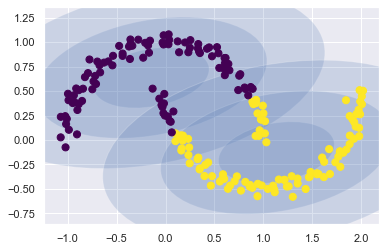

In [21]:
# estimate model parameters with the EM algorithm using two gaussians, initialization seed and full covariance 
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
my_module.plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

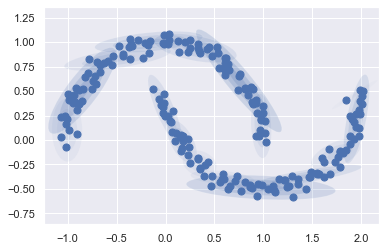

In [22]:
# estimate model parameters with the EM algorithm using sixteen gaussians, initialization seed and full covariance 
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
my_module.plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

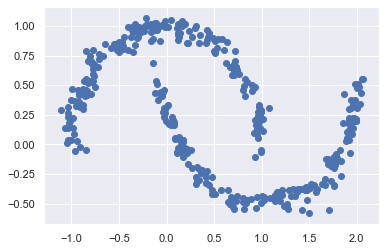

In [23]:
# generate 400 new random samples from the fitted Gaussian distribution.
[Xnew, ynew] = gmm16.sample(n_samples=400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);
# print (ynew) # clusters

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

**The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.**


**A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.**
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

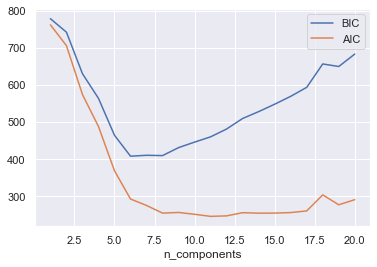

In [24]:
# define a list of number of components (gaussian functions) to be evaluated
n_components = np.arange(1, 21)

# estimate models parameters with the EM algorithm and the list of components
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

# plot the results of the AIC and BIC estimators (models.bic and models.aic)
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

**El eje de la y nos dice cuanta información perdemos, así que cuanto menor mejor. Queremos minimizar AIc y BIC**

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

<br>
<font color='red'>TASK: Using the 'Wisconsin Diagnostic Breast Cancer' employed in the previous PCA notebook (available in the ./data folder of this notebook), the students will perform the following tasks: a) Read the dataset; b) Perform a PCA analysis over the data; c) Project the data into the PC space; d) Apply both k-means and GMM over the projected data; e) Compare the obtained clusters with the real labels.
</font> 


La PCA la hacemos sobre 4 componentes. Podemos probar hacer K-means sobre las 4 componentes, y luego sobre las 2 dimensiones que lo explican. En este caso hacer K-means sobre 2 dimensiones (componentes) ya está bien porque podemos explicar el 99%. 

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
# sklearn includes kmeans algorithm
from sklearn.cluster import KMeans

### Apartado a) Read the dataset

Cargamos los datos del fichero "wdbc.csv" que contiene información sobre la imagen tomada del núcleo de células mamarias. Los datos proceden de la siguiente página web [Web Link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

En esta misma págia web nos indican que los datos tienen 32 características, siendo la primera el ID del paciente y la segunda la etiqueta asociada a la muestra tomada (M = maligno, B = benigno). Los datos corresponden a 569 pacientes, 357 con la etiqueta benigno y 212 con la etiqueta maligno. De las 32 características, no emplearemos las 2 primeras y trabajaremos con las 30 restantes, pues son las que verdadramente aportan la información para llevar a cabo la reducción de dimensionalidad y agrupación. 

In [26]:
import pandas as pd

# Cargamos los datos
data = pd.read_csv('./data/wdbc.csv',header=None) # no hay encabezado

# Eliminanos las dos primeras columnas
X = data.values[ :, 2:].astype(np.float)

# Transformación  a data frame para poder visualizarlo y hacerle el head
df_wdbc = pd.DataFrame(X)
print(df_wdbc.shape) # comprobamos dimensiones. 569 pacientes, 30 características
df_wdbc.head(5)

(569, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Apartado b) Perform a PCA analysis over the data

En este apartado vamos a proceder a realizar una reducción de la dimensionalidad mediante PCA. Al igual que hicimos en la práctica anterior, la reducción de la dimensionalidad se realiza comprobando cuanta varianza retenemos. 

Igualmente, la naturaleza de los datos nos obliga a normalizarlos antes de realizar la reducción de dimensionalidad. En la página web de donde proceden los datos [Web Link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) explcian que las 30 características proceden de 10 mediciones diferentes que se realizan en los 3 ejes dimensionales (radio, textura, perímetro, área, fluidez, compactación, concavidad, puntos cóncavos, simetría y dimensión fractal). Se puede comprobar en el data frame anterior que el orden de magnitud de cada una de las características anteriores es diferente, por lo que es necesario normalizar los datos antes de proceder a realizar la PCA. La importancia de la normalización se comenta de forma más detallada en el siguiente enlace ([link](https://plot.ly/python/v3/ipython-notebooks/principal-component-analysis/)), quedando claro que para obtener conclusiones correctas a partir de nuestros datos, debemos normalizar y eliminar cualquier sesgo procedente de la escala de medida empleada para las diferentes características. 

Con el fin de visualizar el efecto de la normalización, en el presente notebook se realizan los diferentes pasos tanto con los datos normalizados como con los datos sin normalizar. En ambos casos se calcula el número de dimensiones necesarias para retener el 99% de nuestros datos tras realizar una PCA. 

**1. Sin normalizar**

In [27]:
# SIN NORMALIZAR
# Hacemos PCA.
pca = PCA() 
df_wbcd_pca = pca.fit(X).transform(X)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99) + 1  # más uno porque hay que incluir el que supera el 0.99
varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes]
print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)



Número de componentes necesarias para explicar el 99% de la varianza: 2 
La varianza que consigues explicar con estos componentes es: 0.9997786721191878


**2. Normalizando**

In [28]:
# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)

# Hacemos PCA.
pca_std = PCA() # PCA normalizada
df_wbcd_std_pca = pca_std.fit(df_wbcd_std).transform(df_wbcd_std)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca_std.explained_variance_ratio_) <= 0.99) + 1  # más uno porque hay que incluir el que supera el 0.99
varianza_expl = np.cumsum(pca_std.explained_variance_ratio_)[n_componentes-1]
print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)

# Vemos cuantas componentes necesitamos para retener el 90% de la varianza
n_componentes = sum(np.cumsum(pca_std.explained_variance_ratio_) <= 0.90) + 1  # más uno porque hay que incluir el que supera el 0.99
varianza_expl = np.cumsum(pca_std.explained_variance_ratio_)[n_componentes-1]
print("\nNúmero de componentes necesarias para explicar el 90% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)

print("\nCon dos componentes explicamos:", np.cumsum(pca_std.explained_variance_ratio_)[1])

print("\nCon tres componentes explicamos:", np.cumsum(pca_std.explained_variance_ratio_)[2])

Número de componentes necesarias para explicar el 99% de la varianza: 17 
La varianza que consigues explicar con estos componentes es: 0.9911301840050235

Número de componentes necesarias para explicar el 90% de la varianza: 7 
La varianza que consigues explicar con estos componentes es: 0.9100953006967308

Con dos componentes explicamos: 0.632432076515594

Con tres componentes explicamos: 0.7263637090899079


Con los resultados obtenidos, comprobamos la importancia de la normalización. Los datos sin normalizar indican que con solo 2 características se puede llegar a explicar el 99% de la varianza de nuestros datos. No obstante, en el caso de los datos normalizados, se requieren 17 dimensiones para explicar el 99% de la varianza o 7 dimensiones para explicar el 90% de la misma, llegándose tan solo a retener un 63% y un 72% de la varianza con 2 y 3 dimensiones, respectivamente. 

### Apartado c) Project the data into the PC space




TEMPORAL
He conseguido ver como plotear en 3D. Enlace [link](https://stackoverflow.com/questions/49564844/3d-pca-in-matplotlib-how-to-add-legend). La idea era representar en 3D los principales componentes y en 2D los dos principales componentes para demostrar que con 2 ya explicamos suficientes. Luego haríamos el K-means especificando PCA(n_components = 2) y otro K-means para PCA() para que trabaje en todas las dimensiones. Esto era porque veíamos en un ejemplo de clase que cuando hacíamos k-means un grupo de puntos de un cluster se separaba y se movia a otro clster (con el mismo color que el cluster del que se separó). Esto se debía a que representábamos en 2D un K-menas que usaba todas las dimensiones no sólo 2. El objetivo en nuestro ejemplo es demostrar que eso no pasa, porque usar 2D en estos datos explica mucho la varianza por lo que no debería variar muy poco un K means con 2 componentes o un K means con todos los componentes. 

A continuación, se procede a visualizar los datos normalizados y sin normalizar tras realizar la PCA en 2 y 3 dimensiones. Se ha empleado la función "draw_vector" vista en la práctica anterior, para visualizar la dirección de los 2 primeros componentes. La función "draw_vector" se ha incorporado al archivo "my_module.py" de esta práctica. 

In [29]:
import sys
sys.path.append('./my_modules')

#my_module is an example of python module created to include your functions
import my_module

## PCA plot con 2 componentes

**1. Sin normalizar**

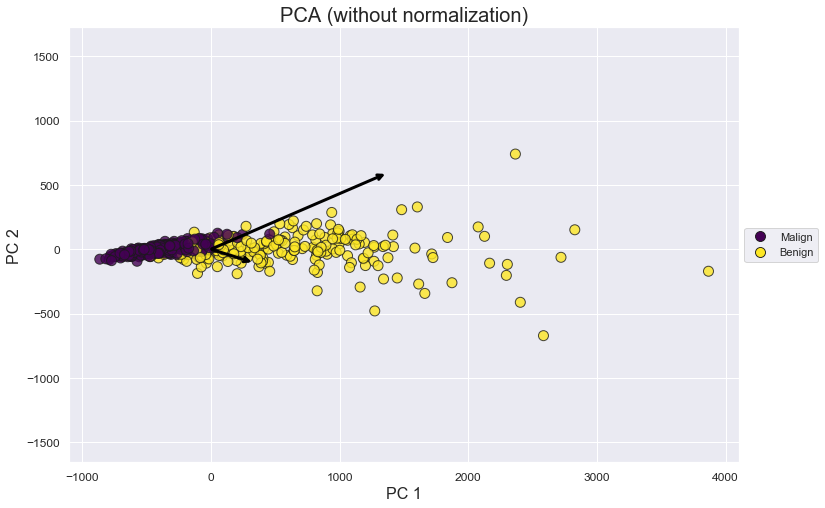

In [30]:
# SIN NORMALIZAR

# Hacemos PCA.
pca = PCA(n_components=2) 


df_wbcd_pca = pca.fit(X).transform(X)

# Datos para plotear sin etiquetas
X_pca = np.array(df_wbcd_pca)

# Generamos un nuevo data frame que contenga las etiquetas de Benigno o Maligno y lo guardamos en un array
df_wdbc_completo = pd.DataFrame(data)
y = np.array(list(df_wdbc_completo[:][1] == "M")).astype(float)

# Tamaño de la figura
fig = plt.figure(figsize=(12,8))
# Ploteamos en formato scatter 
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], s=100, c=y, cmap='viridis',
           marker = 'o', edgecolor='k', alpha = 0.8);

# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5))


# Generamos el título y los nombres de los ejes
plt.title("PCA (without normalization)", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


# Mostramos los vectores de los dos principales componentes (empleando la función draw_vector)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 400* np.sqrt(length)
    my_module.draw_vector(pca_std.mean_[0:2], pca_std.mean_[0:2]+ v[0:2])
    
plt.axis('equal');

**2. Normalizando**

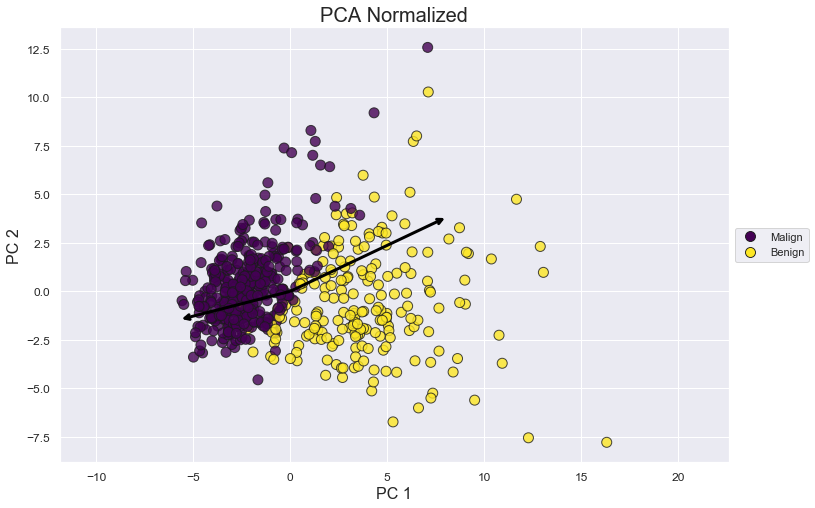

In [31]:
# NORMALIZANDO

# Hacemos PCA.
pca_std = PCA(n_components = 2) # PCA normalizada
df_wbcd_std_pca = pca_std.fit(df_wbcd_std).transform(df_wbcd_std)

# Datos para plotear sin etiquetas
X_pca_std = np.array(df_wbcd_std_pca)

# Generamos un nuevo data frame que contenga las etiquetas de Benigno o Maligno y lo guardamos en un array
df_wdbc_completo = pd.DataFrame(data)
y = np.array(list(df_wdbc_completo[:][1] == "M")).astype(float)

# Tamaño de la figura
fig = plt.figure(figsize=(12,8))
# Ploteamos en formato scatter 
sc = plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], s=100, c=y, cmap='viridis',
           marker = 'o', edgecolor='k', alpha = 0.8);

# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5))

# Generamos el título y los nombres de los ejes
plt.title("PCA Normalized", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


# Mostramos los vectores de los dos principales componentes
for length, vector in zip(pca_std.explained_variance_, pca_std.components_):
    v = vector * 10* np.sqrt(length)
    my_module.draw_vector(pca_std.mean_[0:2], pca_std.mean_[0:2]+ v[0:2])

plt.axis('equal');

## PCA plot con 3 componentes principales

**1. Sin normalizar**

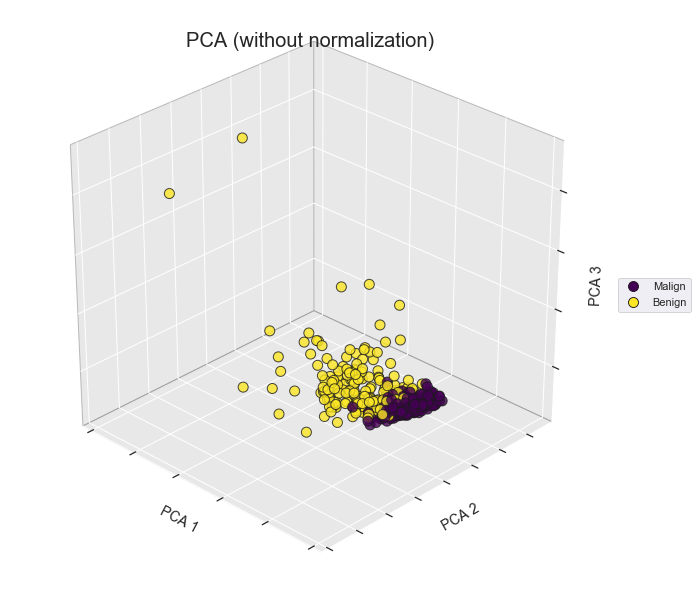

In [32]:
# Plotear 3 D para ver como se ve con las 3 primeras componentes
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components = 3)
df_wbcd_pca = pca.fit(X).transform(X)

# Generamos la figura y los ejes 3D
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=30, azim=134)

# Convertimos el array en data frame para tener los datos disponibles
X_pca=np.array(df_wbcd_pca) # data

# Generamos un nuevo data frame que contenga los datos de Benigno o Maligno y lo guardamos en un array
df_wdbc_completo = pd.DataFrame(data)
y = np.array(list(df_wdbc_completo[:][1] == "M")).astype(float)

# Ploteamos en formato scatter las tres primeras componentes de la PCA
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis',
                 marker = 'o', s = 100, edgecolor='k', alpha = 0.8)

# Lista con la etiqueta y su valor
labelTups = [('Malign', 0), ('Benign', 1)]

# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
ax.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5))

# Establecemos que haya relleno en cada eje
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True

# Color del fondo de cada eje
ax.xaxis.pane.set_facecolor('lightgrey')
ax.yaxis.pane.set_facecolor('lightgrey')
ax.zaxis.pane.set_facecolor('lightgrey')

# Color del borde de cada eje
ax.xaxis.pane.set_edgecolor('grey')
ax.yaxis.pane.set_edgecolor('grey')
ax.zaxis.pane.set_edgecolor('grey')

# Color del fondo de la figura
ax.set_facecolor("w")

# Establecemos los nombres de los ejes y el título
ax.set_title("PCA (without normalization)", fontsize = 20)
ax.set_xlabel('PCA 1', fontsize=14, rotation=150)
ax.set_ylabel('PCA 2', fontsize = 14)
ax.set_zlabel('PCA 3', fontsize=14, rotation=60)

# Quitamos los valores de los ejes para mejor visualización
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

**2. Normalizando**

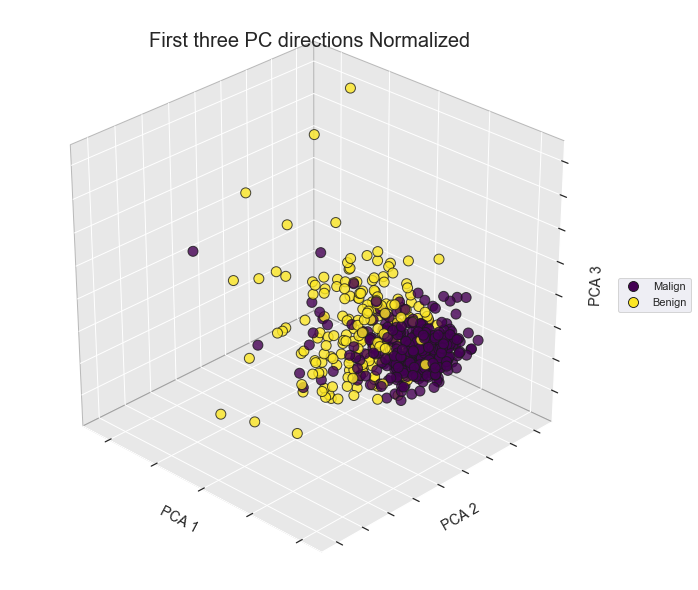

In [33]:
# Hacemos PCA.
pca_std = PCA(n_components = 3) # PCA normalizada
df_wbcd_std_pca = pca_std.fit(df_wbcd_std).transform(df_wbcd_std)

# Generamos la figura y los ejes 3D
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=30, azim=134)

# Convertimos el array en data frame para tener los datos disponibles
X_std_pca=np.array(df_wbcd_std_pca) # data

# Generamos un nuevo data frame que contenga los datos de Benigno o Maligno y lo guardamos en un array
df_wdbc_completo = pd.DataFrame(data)
y = np.array(list(df_wdbc_completo[:][1] == "M"))

# Ploteamos en formato scatter las tres primeras componentes de la PCA
sc = ax.scatter(X_std_pca[:, 0], X_std_pca[:, 1], X_std_pca[:, 2], c=y, cmap='viridis',
                 marker = 'o', s = 100, edgecolor='k', alpha = 0.8)

# Lista con la etiqueta y su valor
labelTups = [('Malign', 0), ('Benign', 1)]

# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
ax.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5))

# Establecemos que haya relleno en cada eje
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True

# Color del fondo de cada eje
ax.xaxis.pane.set_facecolor('lightgrey')
ax.yaxis.pane.set_facecolor('lightgrey')
ax.zaxis.pane.set_facecolor('lightgrey')

# Color del borde de cada eje
ax.xaxis.pane.set_edgecolor('grey')
ax.yaxis.pane.set_edgecolor('grey')
ax.zaxis.pane.set_edgecolor('grey')

# Color del fondo de la figura
ax.set_facecolor("w")

# Establecemos los nombres de los ejes y el título
ax.set_title("First three PC directions Normalized", fontsize = 20)
ax.set_xlabel('PCA 1', fontsize=14, rotation=150)
ax.set_ylabel('PCA 2', fontsize = 14)
ax.set_zlabel('PCA 3', fontsize=14, rotation=60)

# Quitamos los valores de los ejes para mejor visualización
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

  
El método de PCA asume que los datos siguen una distribución normal, es decir, tienen media 0 y varianza igual a 1. Por ello, es necesario la aplicación de un método de normalización, que además elimine el efecto que puedan producir las diferencias asociadas a las escalas empleadas para la medición de cada característica de los datos ([link](https://empresas.blogthinkbig.com/python-para-todos-que-es-el-pca/)).

Normalizando nuestros datos pasamos de retener el 99% de la varianza a retener el 63% y 72% de la varianza con 2 y 3 componentes principales, respectivamente. Esto se observa en las siguientes representaciones 2D y 3D de PCA de nuestros datos antes y después de normalizar. 

En ambos casos vemos que sin normalizar los datos, éstos muestran mayor correlación, puediendo ser explicados con un menor número de componentes. No obstante, los datos tras la normalización muestran una disposición espacial diferente, lo que demuestra que lo observado anteriormente es un artefacto y que nuestros datos han de ser normalizados y que cualquier análisis sin la normalización sería incorrecta. 

### d) Apply both k-means and GMM over the projected data

## Kmean

El algoritmo K-means divide un conjunto de datos en $K$  grupos disjuntos, denominado clúster, cada uno descrito por la media de las muestras en el grupo. Estos puntos medios de los grupos se denominan comúnmente como "centroides", pudiendo no exitir estos centroides en nuestros datos de partida, pero situándose en el mismo espacio que ellos.  

Como se comentaba en las celdas superiores del notebook de esta práctica, el algoritmo K-means tiene dos desventajas principales. 
La primera de ellas es que, por la forma en que trabaja según el mecanismo *inertia* ([link](https://scikit-learn.org/stable/modules/clustering.html#k-means)), solo es capaz de generar agrupaciones con formas circulares. En función de cómo se distribuyan los datos de estudio, la agrupación circular puede no ser adecuada. 

En segundo lugar, el algortimo K-means no nos asegura obtener la agrupación óptima global, siendo recomendable realizar varias inicializaciones aleatorias de los centroides para asegurar que obtenemos una agrupación que minimiza la distancias de los puntos a los centroides. Otra característica de K-means es que requiere conocer previamente el número de clústeres que se quieren obtener. En nuestro caso no es un problema porque sabemos que nuestros datos tienen 2 posibles etiquetas (M = maligno, B = benigno). No obstante, los criterios de información de Akaike (AIC) y Bayes (BIC) o el método del "codo" nos permiten estimar cuál sería el número de grupos ($K$) óptimo para clasificar nuestros datos. 

Como se comenta en la documentación de scikitlearn ([link](https://scikit-learn.org/stable/modules/clustering.html#k-means)) el algoritmo K-means funciona minimizando el criterio denominado *inertia*. Este criterio consiste en minimizar la distancia Euclediana de los datos a los centroides: 


$$\sum_{i=0}^{n}{min(||x_i - \mu_j||^2)}$$

Donde:

* $n$ corresponde al número de datos
* $x_i$ el dato $i$ del conjunto de datos
* $\mu_j$ es el centroide $j$ del conjunto de centroides (clústeres) definidos

En relación a este método empleado por K-means surge el problema denominado "maldición de la dimensionalidad". Este problema está asociado con que en las situaciones en las que incluímos un gran número de dimensiones en el  las distancias euclidianas tienden a inflarse, dado que gran cantidad del espacio considerado se encuentra vacío. En la documentación se indica que una de las formas para aliviar este problema es realizar una PCA previa, con lo que conseguiremos además acelerar los cálculos. 

A continuación, se muestran los resultados del algoritmo K-means sobre los datos normalizados (previamente concluímos que era necesario normalizar) y tratados con PCA. Se han representado los límites de los clústeres generados con la función "plot_kmeans" del documento "my_module.py", a la cuál se le ha incorporado argumentos adicionales relacionados con la estética de la gráfica. Igualmente, se ha incorporado el parámetro "n_init" en la función K-means dado que el número de grupos deseado es 2 y queremos asegurar que se encuentre la mejor solución posible. Además, se ha fijado la semilla "random_state = 42" en todos los experimentos (tanto en K-means como GMM). Se ha elegido esta semilla de forma aleatoria y simplemente porque aparece en las celdas previas de este notebook. No se ha intentado en ningún caso optimizar el parámetro "random_state" dado que provocaría sesgo en nuestros resultados ([link](https://stats.stackexchange.com/questions/263999/is-random-state-a-parameter-to-tune)). 

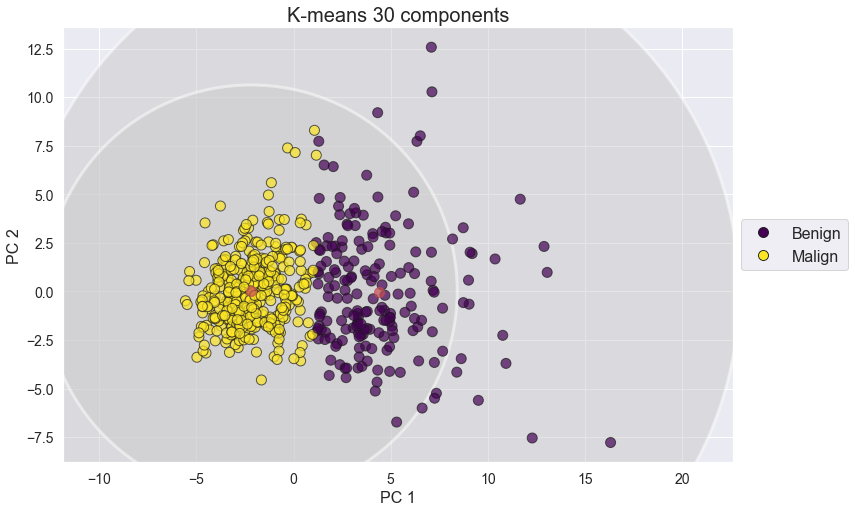

<Figure size 432x288 with 0 Axes>

In [83]:
# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)


# Hacemos PCA para 30 componentes.
pca30 = PCA(n_components=30) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca30.fit(df_wbcd_std).transform(df_wbcd_std)


X_std_pca=np.array(df_wbcd_std_pca)

# perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init = 10)
kmeans.fit(X_std_pca)
y_kmeans = kmeans.predict(X_std_pca)
labels = kmeans.fit_predict(X_std_pca)

fig = plt.figure(figsize=(12,8))

# Generamos las etiquetas
label_legend = [('Benign', 1), ('Malign', 0)]

# Dibujamos los centroides
centers, labels = my_module.find_clusters(df_wbcd_std_pca, 2)
plt.plot(centers[1][0], centers[1][1],'r', ms = 10, alpha = 0.7, marker = 'o')
plt.plot(centers[0][0], centers[0][1],'r', ms = 10, alpha = 0.7, marker = 'o')

plt.title("K-means 30 components", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Dibujamos las elipses
plt.figure(my_module.plot_kmeans(kmeans, X_std_pca, s= 100, edgecolor = 'k', marker = 'o', alpha = 0.7,
                                   label_legend = label_legend, fontsize = 16))
# plt.savefig('foo.pdf')
fig.savefig("K-means_30.pdf", bbox_inches='tight')

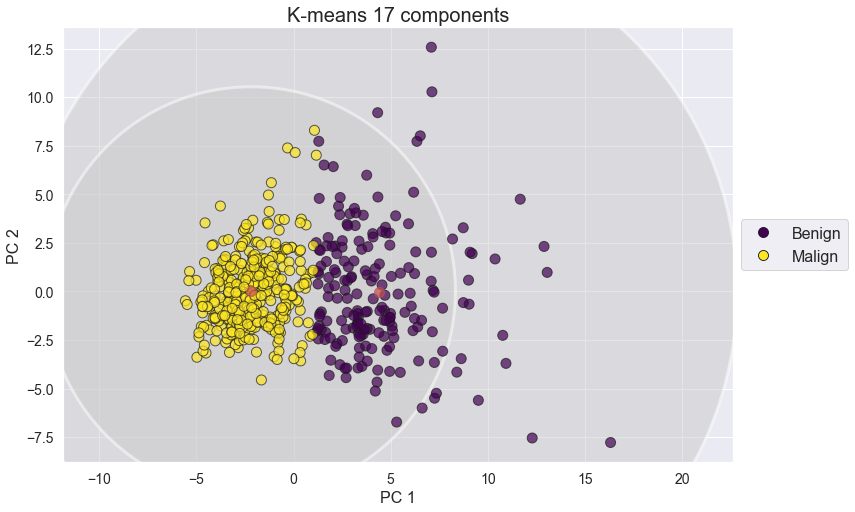

<Figure size 432x288 with 0 Axes>

In [60]:
# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)


# Hacemos PCA para 17 componentes.
pca30 = PCA(n_components=17) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca30.fit(df_wbcd_std).transform(df_wbcd_std)


X_std_pca=np.array(df_wbcd_std_pca)

# perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init = 10)
kmeans.fit(X_std_pca)
y_kmeans = kmeans.predict(X_std_pca)

labels = kmeans.fit_predict(X_std_pca)

fig = plt.figure(figsize=(12,8))

# Generamos las etiquetas
label_legend = [('Benign', 0), ('Malign', 1)]

# Dibujamos los centroides
centers, labels = my_module.find_clusters(df_wbcd_std_pca, 2)
plt.plot(centers[1][0], centers[1][1],'r', ms = 10, alpha = 0.7, marker = 'o')
plt.plot(centers[0][0], centers[0][1],'r', ms = 10, alpha = 0.7, marker = 'o')

plt.title("K-means 17 components", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Dibujamos las elipses
_ = plt.figure(my_module.plot_kmeans(kmeans, X_std_pca, s= 100, edgecolor = 'k', marker = 'o', alpha = 0.7,
                                   label_legend = label_legend, fontsize = 16))

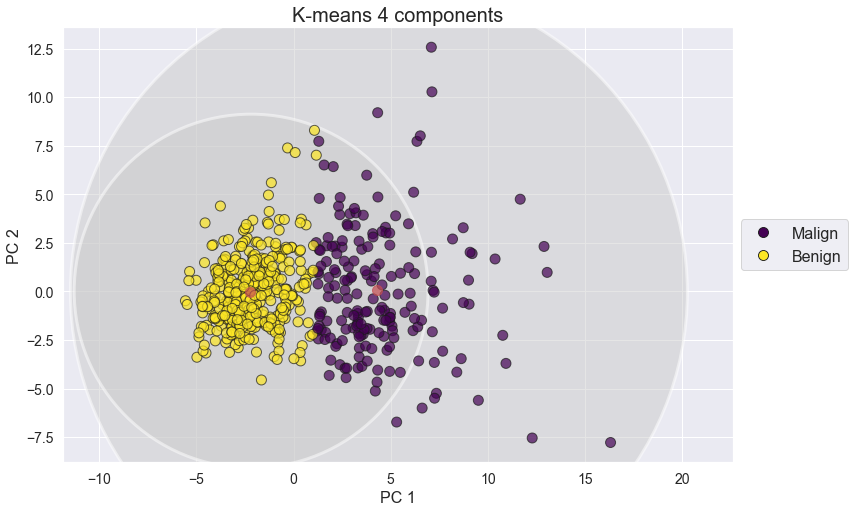

<Figure size 432x288 with 0 Axes>

In [61]:
# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)


# Hacemos PCA para 4 componentes.
pca30 = PCA(n_components=4) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca30.fit(df_wbcd_std).transform(df_wbcd_std)


X_std_pca=np.array(df_wbcd_std_pca)

# perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init = 10)
kmeans.fit(X_std_pca)
y_kmeans = kmeans.predict(X_std_pca)
labels = kmeans.fit_predict(X_std_pca)

fig = plt.figure(figsize=(12,8))

# Generamos las etiquetas
label_legend = [('Malign', 0), ('Benign', 1)]

# Dibujamos los centroides
centers, labels = my_module.find_clusters(df_wbcd_std_pca, 2)
plt.plot(centers[1][0], centers[1][1],'r', ms = 10, alpha = 0.7, marker = 'o')
plt.plot(centers[0][0], centers[0][1],'r', ms = 10, alpha = 0.7, marker = 'o')

plt.title("K-means 4 components", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Dibujamos las elipses
_ = plt.figure(my_module.plot_kmeans(kmeans, X_std_pca, s= 100, edgecolor = 'k', marker = 'o', alpha = 0.7,
                                    label_legend = label_legend, fontsize = 16))

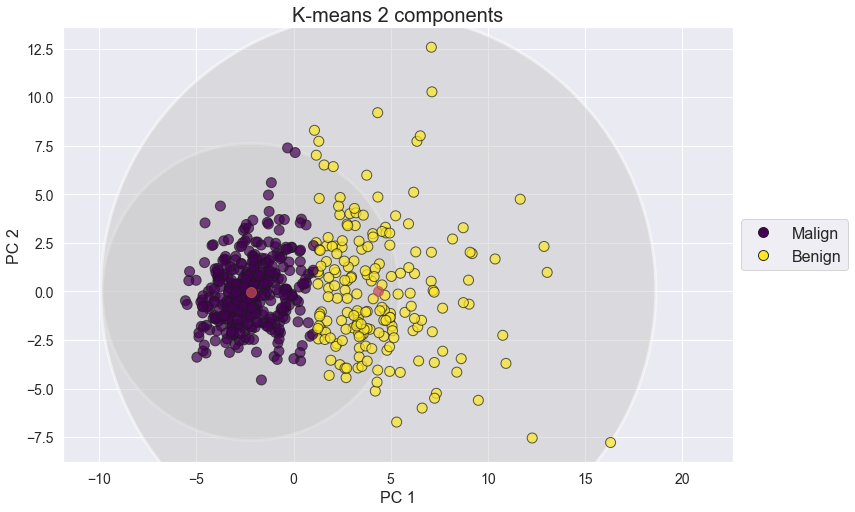

<Figure size 432x288 with 0 Axes>

In [80]:
# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)


# Hacemos PCA para 2 componentes.
pca30 = PCA(n_components=2) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca30.fit(df_wbcd_std).transform(df_wbcd_std)


X_std_pca=np.array(df_wbcd_std_pca)

# perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init = 10)
kmeans.fit(X_std_pca)
y_kmeans = kmeans.predict(X_std_pca)
labels = kmeans.fit_predict(X_std_pca)

fig = plt.figure(figsize=(12,8))

# Generamos las etiquetas
label_legend = [('Malign', 0), ('Benign', 1)]

# Dibujamos los centroides
centers, labels = my_module.find_clusters(df_wbcd_std_pca, 2)
plt.plot(centers[1][0], centers[1][1],'r', ms = 10, alpha = 0.7, marker = 'o')
plt.plot(centers[0][0], centers[0][1],'r', ms = 10, alpha = 0.7, marker = 'o')

plt.title("K-means 2 components", fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Dibujamos las elipses
_ = plt.figure(my_module.plot_kmeans(kmeans, X_std_pca, s= 100, edgecolor = 'k', marker = 'o', alpha = 0.7,
                                    label_legend = label_legend, fontsize = 16))

fig.savefig("K-means_2.pdf", bbox_inches='tight')

A continuación, mostramos la clasificación real de los datos:

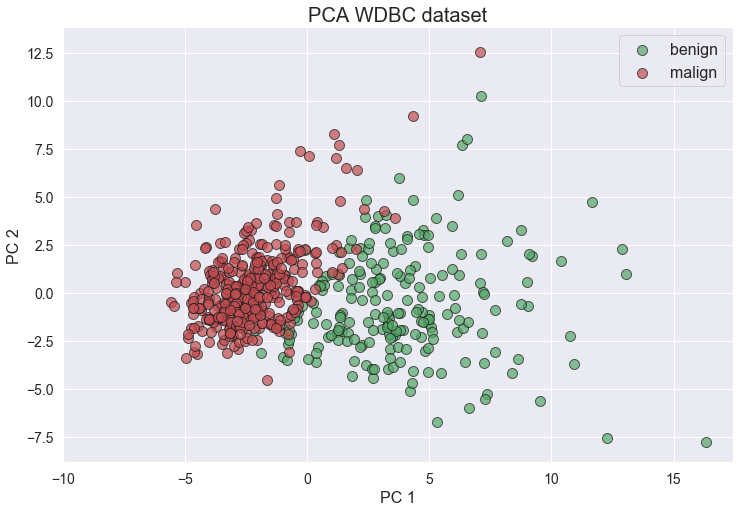

In [53]:
y = (data.values[ :, 1 ] == 'B').astype(np.int)
target_names = np.array([('benign'), ('malign')], dtype=np.dtype('U10'))

fig = plt.figure(figsize=(12,8))
comp1=0; #first component to visualize, you can modify it
comp2=1; #second component to visualize, you can modify it


plt.axis(xlim=(0, 10), ylim=(0, 10))
# plot the two components selected above for both malign and benign tumors
plt.scatter(df_wbcd_std_pca[y == 0, comp1], df_wbcd_std_pca[y == 0, comp2], color='g', alpha=.7, lw=1,
                label='benign', s = 100, edgecolor = "k")

plt.scatter(df_wbcd_std_pca[y == 1, comp1],df_wbcd_std_pca[y == 1, comp2], color='r', alpha=.7, lw=1,
                label='malign', s = 100, edgecolor = "k")

plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize = 16)
plt.title('PCA WDBC dataset', fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(np.arange(-10, 20, 5), fontsize = 14)
plt.yticks(np.arange(-7.5, 13, 2.5), fontsize = 14)

plt.show()


Comparación entre utilizar las 30 componentes en el kmeans o solo 2. Puesto que 2 componentes de la PCA son suficientes para acumular la mayoria de la varianza, los clusters formados por kmeans no distaran significativamente, independientemente de las dimensiones que nos quitemos




### Conclusiones resultados K-means:

Con los resultados obtenidos y comparando con el resultado "real" que debería obtenerse, vemos que K-means no es el algortimo más adecuado para llevar a cabo una agrupación de los datos. Esto se debe a una de las desventajas comentadas anteriormente. Si nos fijamos en el resultado "real" los datos con la etiqueta maligna se distribuyen de forma elíptica, por lo que la limitación de K-means a la hora de generar grupos con formas circulares impide que el resultado calculado sea adecuado. Esto ocurre independientemente del número de dimensiones que se incluyan en K-means. 

Asimismo, sí se observa el efecto de incluir mayor número de componentes y, por tanto más varianza retenida, en la agrupación. El efecto se observa tanto en el tamaño de los círculos dibujados con la función "plot_kmeans" como en la asignación de los puntos a los clústeres. Observamos que a medida que incorporamos mayor número de componentes en la PCA sobre la que trabaja K-means, mayor es el tamaño de los círculos de ambos clústeres. Esto tiene sentido dado que estamos incorporando mayor cantidad de varianza en nuestros datos. De igual modo, se observa que cuando se emplean sólo dos componentes (63% de varianza retenida), dos puntos (señalados en las imágenes de abajo) cambian su etiqueta cuando se incorporan nuevas componentes en el estudio: 

In [84]:
from IPython.display import IFrame
IFrame("K-means_30.pdf", width=1000, height=500)

In [81]:
IFrame("K-means_2.pdf", width=1000, height=500)

# GMM 

Volvemos a leer los archivos de entrada para asegurarnos que no se emplean valores presentes en el ambiente. 

GMM con PCA de 30 componentes de datos normalizados

Número de componentes necesarias para explicar el 99% de la varianza: 17 
La varianza que consigues explicar con estos componentes es: 0.9911301840050235


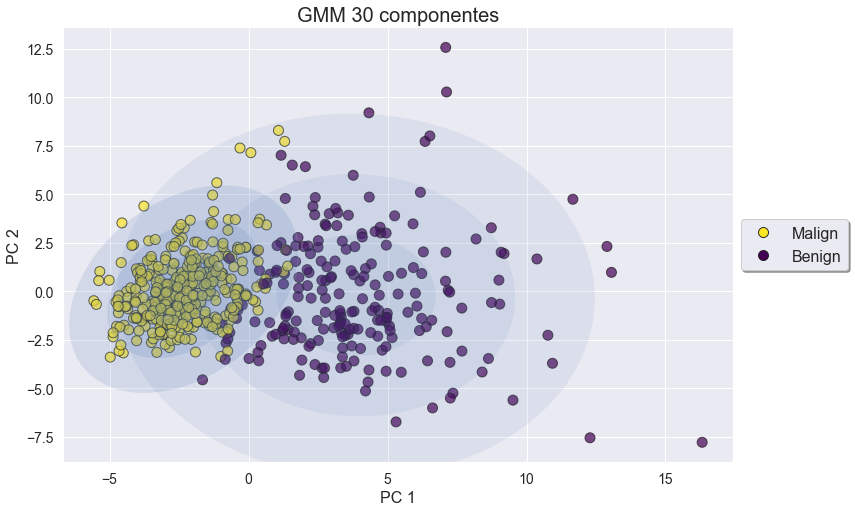

In [39]:
# Para 30 componentes
pca = PCA(n_components=30) 

# Ajustamos PCA
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)+1 # más uno porque hay que incluir el que supera el 0.99

if n_componentes >= len(pca.explained_variance_ratio_):
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[ len(pca.explained_variance_ratio_)-1]
    print("\nLa varianza que consigues explicar con el total de "+str(len(pca.explained_variance_ratio_))+" \
componentes es:", varianza_expl)
else:
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes-1]
    print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)


# Estimamos los parámetos para GMM para 2 distribuciones, es decir, dos agrupaciones
# n_init = 10 para que realice 10 inicios diferentes y se quede con el mejor resultado
gmm = GMM(n_components=2, random_state=42, covariance_type='full', n_init = 10).fit(X_std_pca)

# predict the labels for the data samples in X using trained model and select only 2 components to draw the covariance ellipse
# asigna etiquetas para los datos en X_std_pca 
labels = gmm.predict(X_std_pca)

# Selecciona 2 componentes para dibujar la elipse de covarianza
cov_raw = gmm.covariances_[0:2]
cov_0= np.concatenate((np.array([cov_raw[0][0][0:2]]), np.array([cov_raw[0][1][0:2]])), axis=0)
cov_1= np.concatenate((np.array([cov_raw[1][0][0:2]]), np.array([cov_raw[1][1][0:2]])), axis=0)
# Agrupamos en un array los valores de covarianza para las 2 primeras dimensiones
cov = np.concatenate((np.array([cov_0]), np.array([cov_1])), axis = 0)


# Tamaño del grafico
fig = plt.figure(figsize=(12,8))


# Representación de los datos en 2D 
sc = plt.scatter(X_std_pca[:, 0], X_std_pca[:, 1], c=labels, s=100, cmap='viridis', 
            alpha=.7, lw=1,  edgecolor = "k", marker = 'o');


# Dibuja la elipse a partir de la matriz de covarianza
w_factor = 0.15 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, cov, gmm.weights_):
    my_module.draw_ellipse(pos, covar, alpha=w * w_factor)
    
    
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('GMM 30 componentes', fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [1, 0]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
_ = plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5), shadow=True, fontsize = 16)

GMM con PCA de 17 componentes de datos normalizados


La varianza que consigues explicar con el total de 17 componentes es: 0.9911301840050231


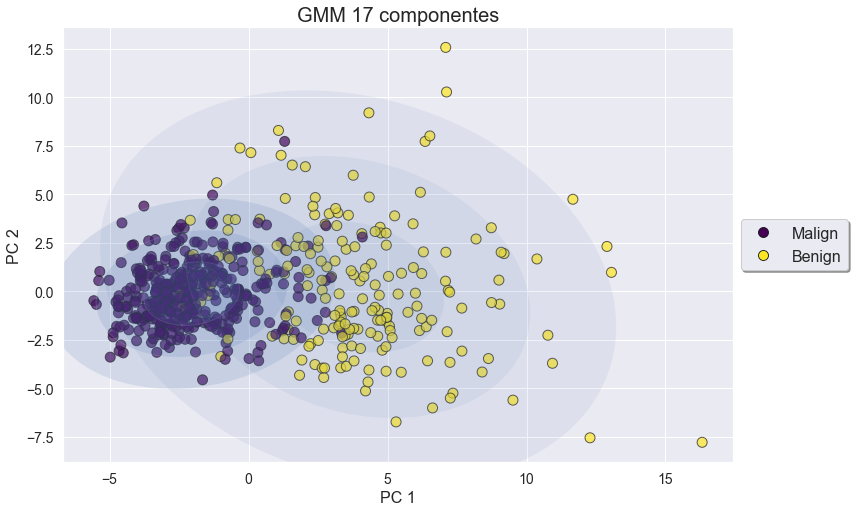

In [40]:
# import the Gaussian Mixture Model algorithm from sklearn
from sklearn.mixture import GaussianMixture as GMM

data = pd.read_csv('./data/wdbc.csv',header=None) #as there is no header in this case

# Me quito las dos primeras columnas
X = data.values[ :, 2:].astype(np.float)

# lo paso a data frame para poder visualizarlo y hacerle el head
df_wdbc = pd.DataFrame(X)

# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)

# Para 17 componentes
pca = PCA(n_components=17) 

# Ajustamos PCA
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)+1 # más uno porque hay que incluir el que supera el 0.99

if n_componentes >= len(pca.explained_variance_ratio_):
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[ len(pca.explained_variance_ratio_)-1]
    print("\nLa varianza que consigues explicar con el total de "+str(len(pca.explained_variance_ratio_))+" \
componentes es:", varianza_expl)
else:
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes-1]
    print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)


# Estimamos los parámetos para GMM para 2 distribuciones, es decir, dos agrupaciones
# n_init = 10 para que realice 10 inicios diferentes y se quede con el mejor resultado
gmm = GMM(n_components=2, random_state=42, covariance_type='full', n_init = 10).fit(X_std_pca)

# predict the labels for the data samples in X using trained model and select only 2 components to draw the covariance ellipse
# asigna etiquetas para los datos en X_std_pca 
labels = gmm.predict(X_std_pca)

# Selecciona 2 componentes para dibujar la elipse de covarianza
cov_raw = gmm.covariances_[0:2]
cov_0= np.concatenate((np.array([cov_raw[0][0][0:2]]), np.array([cov_raw[0][1][0:2]])), axis=0)
cov_1= np.concatenate((np.array([cov_raw[1][0][0:2]]), np.array([cov_raw[1][1][0:2]])), axis=0)
# Agrupamos en un array los valores de covarianza para las 2 primeras dimensiones
cov = np.concatenate((np.array([cov_0]), np.array([cov_1])), axis = 0)


# Tamaño del grafico
fig = plt.figure(figsize=(12,8))


# Representación de los datos en 2D 
sc = plt.scatter(X_std_pca[:, 0], X_std_pca[:, 1], c=labels, s=100, cmap='viridis', 
            alpha=.7, lw=1,  edgecolor = "k", marker = 'o');


# Dibuja la elipse a partir de la matriz de covarianza
w_factor = 0.15 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, cov, gmm.weights_):
    my_module.draw_ellipse(pos, covar, alpha=w * w_factor)
    
    
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('GMM 17 componentes', fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
_ = plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5), shadow=True, fontsize = 16)


La varianza que consigues explicar con el total de 4 componentes es: 0.7923850582401605


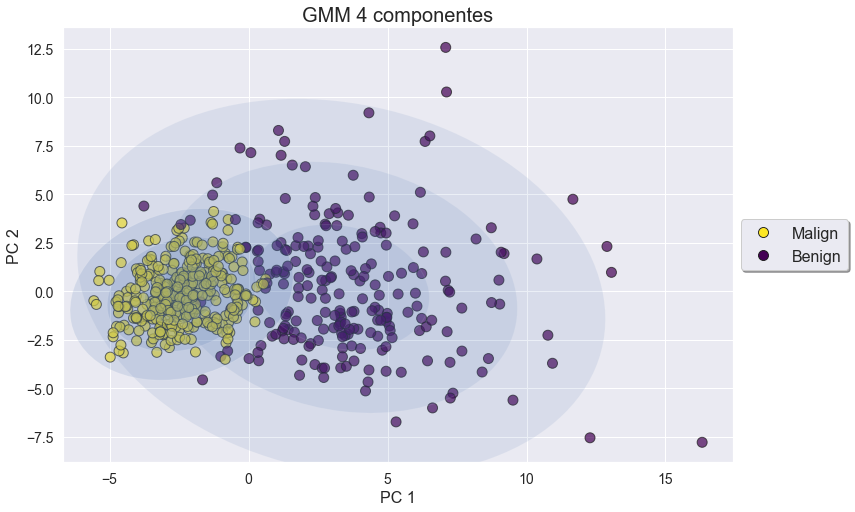

In [41]:
# Para 4 componentes
pca = PCA(n_components=4) 

# Ajustamos PCA
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)+1 # más uno porque hay que incluir el que supera el 0.99

if n_componentes >= len(pca.explained_variance_ratio_):
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[ len(pca.explained_variance_ratio_)-1]
    print("\nLa varianza que consigues explicar con el total de "+str(len(pca.explained_variance_ratio_))+" \
componentes es:", varianza_expl)
else:
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes-1]
    print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)


# Estimamos los parámetos para GMM para 2 distribuciones, es decir, dos agrupaciones
# n_init = 10 para que realice 10 inicios diferentes y se quede con el mejor resultado
gmm = GMM(n_components=2, random_state=42, covariance_type='full', n_init = 10).fit(X_std_pca)

# predict the labels for the data samples in X using trained model and select only 2 components to draw the covariance ellipse
# asigna etiquetas para los datos en X_std_pca 
labels = gmm.predict(X_std_pca)

# Selecciona 2 componentes para dibujar la elipse de covarianza
cov_raw = gmm.covariances_[0:2]
cov_0= np.concatenate((np.array([cov_raw[0][0][0:2]]), np.array([cov_raw[0][1][0:2]])), axis=0)
cov_1= np.concatenate((np.array([cov_raw[1][0][0:2]]), np.array([cov_raw[1][1][0:2]])), axis=0)
# Agrupamos en un array los valores de covarianza para las 2 primeras dimensiones
cov = np.concatenate((np.array([cov_0]), np.array([cov_1])), axis = 0)


# Tamaño del grafico
fig = plt.figure(figsize=(12,8))


# Representación de los datos en 2D 
sc = plt.scatter(X_std_pca[:, 0], X_std_pca[:, 1], c=labels, s=100, cmap='viridis', 
            alpha=.7, lw=1,  edgecolor = "k", marker = 'o');


# Dibuja la elipse a partir de la matriz de covarianza
w_factor = 0.15 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, cov, gmm.weights_):
    my_module.draw_ellipse(pos, covar, alpha=w * w_factor)
    
    
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('GMM 4 componentes', fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [1, 0]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
_ = plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5), shadow=True, fontsize = 16)


La varianza que consigues explicar con el total de 2 componentes es: 0.6324320765155941


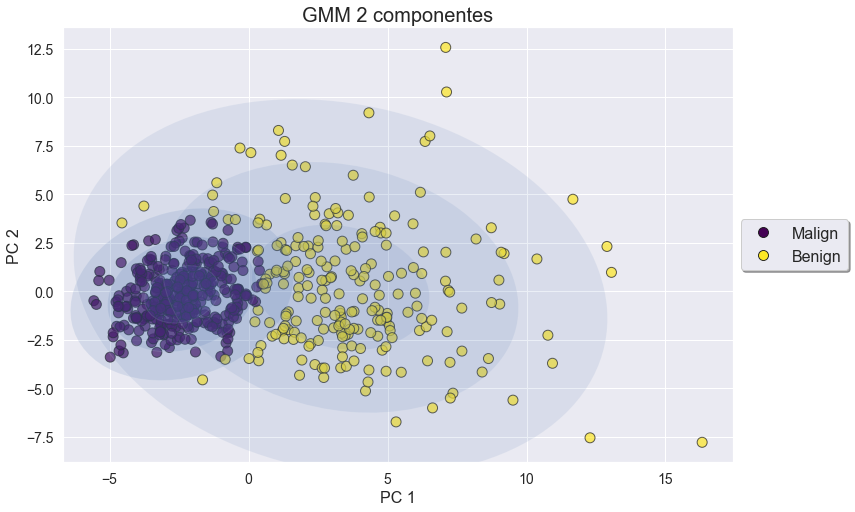

In [42]:
# Para 2 componentes
pca = PCA(n_components=2) 

# Ajustamos PCA
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)+1 # más uno porque hay que incluir el que supera el 0.99

if n_componentes >= len(pca.explained_variance_ratio_):
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[ len(pca.explained_variance_ratio_)-1]
    print("\nLa varianza que consigues explicar con el total de "+str(len(pca.explained_variance_ratio_))+" \
componentes es:", varianza_expl)
else:
    varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes-1]
    print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)


# Estimamos los parámetos para GMM para 2 distribuciones, es decir, dos agrupaciones
# n_init = 10 para que realice 10 inicios diferentes y se quede con el mejor resultado
gmm = GMM(n_components=2, random_state=42, covariance_type='full', n_init = 10).fit(X_std_pca)

# predict the labels for the data samples in X using trained model and select only 2 components to draw the covariance ellipse
# asigna etiquetas para los datos en X_std_pca 
labels = gmm.predict(X_std_pca)

# Selecciona 2 componentes para dibujar la elipse de covarianza
cov_raw = gmm.covariances_[0:2]
cov_0= np.concatenate((np.array([cov_raw[0][0][0:2]]), np.array([cov_raw[0][1][0:2]])), axis=0)
cov_1= np.concatenate((np.array([cov_raw[1][0][0:2]]), np.array([cov_raw[1][1][0:2]])), axis=0)
# Agrupamos en un array los valores de covarianza para las 2 primeras dimensiones
cov = np.concatenate((np.array([cov_0]), np.array([cov_1])), axis = 0)


# Tamaño del grafico
fig = plt.figure(figsize=(12,8))


# Representación de los datos en 2D 
sc = plt.scatter(X_std_pca[:, 0], X_std_pca[:, 1], c=labels, s=100, cmap='viridis', 
            alpha=.7, lw=1,  edgecolor = "k", marker = 'o');


# Dibuja la elipse a partir de la matriz de covarianza
w_factor = 0.15 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, cov, gmm.weights_):
    my_module.draw_ellipse(pos, covar, alpha=w * w_factor)
    
    
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('GMM 2 componentes', fontsize = 20)
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


# mismos colores para la leyenda
colors = [sc.cmap(sc.norm(i)) for i in [0, 1]]
# generamos los elementos de la leyenda
custom_lines = [plt.Line2D([],[], ls="", marker='.', mec='k', mfc=c, mew=.9, ms=20) for c in colors]
# generamos finalmente la leyenda
_ = plt.legend(custom_lines, ["Malign", "Benign"], 
          loc='center left', bbox_to_anchor=(1.0, .5), shadow=True, fontsize = 16)

GMM con PCA de 4 componentes de datos normalizados

GMM con PCA de 2 componentes de datos normalizados

En GMM 

* Ver que método si K means o GMM funciona mejor normalizado o no

<br>
<font color='red'>ADD YOUR ANALYSIS</font> 
<br>
<br>
<br>
<br>
<br>

## Con 30 componentes

(569, 17)


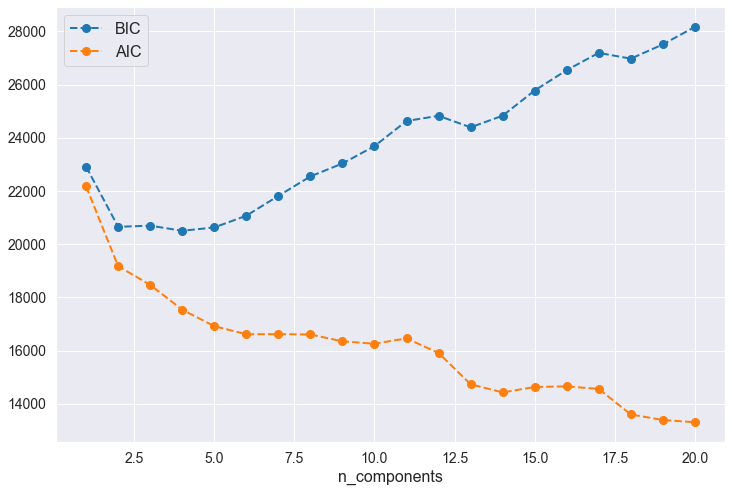

In [43]:
data = pd.read_csv('./data/wdbc.csv',header=None) #as there is no header in this case

# Me quito las dos primeras columnas
X = data.values[ :, 2:].astype(np.float)

# lo paso a data frame para poder visualizarlo y hacerle el head
df_wdbc = pd.DataFrame(X)

# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)

# Hacemos PCA para 4 componentes.
pca = PCA(n_components=17) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)

print(X_std_pca.shape)

# estimate models parameters with the EM algorithm and the list of components
models = [GMM(n, covariance_type='full', random_state=0).fit(X_std_pca)
          for n in n_components]

# plot the results of the AIC and BIC estimators (models.bic and models.aic)
plt.figure(figsize = (12, 8))
plt.plot(n_components, [m.bic(X_std_pca) for m in models], label='BIC',
         linewidth = 2, c = "tab:blue", linestyle='--', marker='o', ms = 8)

plt.plot(n_components, [m.aic(X_std_pca) for m in models], label='AIC',
         linewidth = 2, c = "tab:orange", linestyle='--', marker='o', ms = 8)


plt.xlabel("n_components", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='best', fontsize = 16)
plt.xlabel('n_components');

## Con 2 componentes

(569, 2)


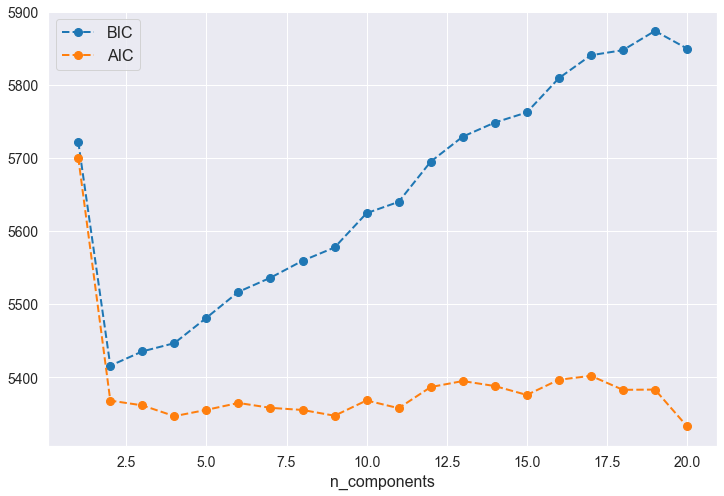

In [44]:
data = pd.read_csv('./data/wdbc.csv',header=None) #as there is no header in this case

# Me quito las dos primeras columnas
X = data.values[ :, 2:].astype(np.float)

# lo paso a data frame para poder visualizarlo y hacerle el head
df_wdbc = pd.DataFrame(X)

# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)

# Hacemos PCA para 2 componentes.
pca = PCA(n_components=2) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)

print(X_std_pca.shape)

# estimate models parameters with the EM algorithm and the list of components
models = [GMM(n, covariance_type='full', random_state=0).fit(X_std_pca)
          for n in n_components]

# plot the results of the AIC and BIC estimators (models.bic and models.aic)
plt.figure(figsize = (12, 8))
plt.plot(n_components, [m.bic(X_std_pca) for m in models], label='BIC',
         linewidth = 2, c = "tab:blue", linestyle='--', marker='o', ms = 8)

plt.xlabel("n_components", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.plot(n_components, [m.aic(X_std_pca) for m in models], label='AIC',
         linewidth = 2, c = "tab:orange", linestyle='--', marker='o', ms = 8)
plt.legend(loc='best', fontsize = 16)
plt.xlabel('n_components');

Podemos comprobar que con solo dos dimensiones se considera que hay dos grupos o clústeres, pero cuando considerams 17 componentes los datos parecen tener como optimización más agrupaciones según AIC. Esto puede ser interesante porque nos podría estar diciendo que dentro de los dos grupos que estamos considerando (Benigno y Maligno) habría que considerar más subgrupos. Esto lo veíamos ya cuando observábamos que los datos se distribuían de forma dispersa y, precisamente, en mayor medida entre los datos de los cánceres malignos. Esto tiene sentido con la biología, porque dentro de los tumores malignos hay heterogeneidad. Quizá sería interesante buscar más grupos. 

## Probando con 3 agrupaciones

Número de componentes necesarias para explicar el 99% de la varianza: 17 
La varianza que consigues explicar con estos componentes es: 0.9911301840050235


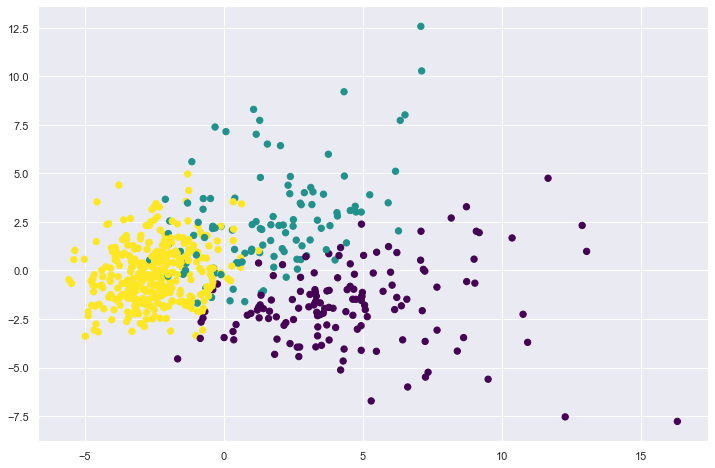

In [45]:
# import the Gaussian Mixture Model algorithm from sklearn
from sklearn.mixture import GaussianMixture as GMM

data = pd.read_csv('./data/wdbc.csv',header=None) #as there is no header in this case

# Me quito las dos primeras columnas
X = data.values[ :, 2:].astype(np.float)

# lo paso a data frame para poder visualizarlo y hacerle el head
df_wdbc = pd.DataFrame(X)

# Normalizamos 
df_wbcd_std = sklearn.preprocessing.StandardScaler().fit_transform(df_wdbc)

# Hacemos PCA para 4 componentes.
pca = PCA(n_components=30) 

# Explicar ploteando solo dos componentes
df_wbcd_std_pca = pca.fit(df_wbcd_std).transform(df_wbcd_std)
X_std_pca = np.array(df_wbcd_std_pca)


# Vemos cuantas componentes necesitamos para retener el 99% de la varianza
n_componentes = sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)+1 # más uno porque hay que incluir el que supera el 0.99
varianza_expl = np.cumsum(pca.explained_variance_ratio_)[n_componentes-1]
print("Número de componentes necesarias para explicar el 99% de la varianza:", n_componentes, 
     "\nLa varianza que consigues explicar con estos componentes es:", varianza_expl)


# estimate model parameters with the EM algorithm, we will use four gaussian functions
gmm = GMM(n_components=3, random_state=42, covariance_type='full', n_init = 5).fit(df_wbcd_std)

# predict the labels for the data samples in X using trained model
labels = gmm.predict(df_wbcd_std)

plt.figure(figsize = (12, 8))
plt.scatter(X_std_pca[:, 0], X_std_pca[:, 1], c=labels, s=40, cmap='viridis');

357 benign, 212 malignant